In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

# --- Define RHS network architecture ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, z):
        x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
        return self.mlp(x)

# --- Load trained model ---
model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_2.eqx"
model = RHS()
model_params = eqx.tree_deserialise_leaves(model_path, model)
model = eqx.combine(model_params, model)

# --- Load H(z) and P(z) initial condition ---
Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_high_res/Hz_all.npy")     # (30000, 50)
pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_high_res/pk_nl_all.npy")  # (30000, 50, 262)
z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_high_res/z.npy")          # (50,)

# Use first sample as reference
Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
z_grid_rev = z_grid[::-1]       # high → low redshift

# Interpolated function H(z), valid for decreasing z
def H_func(z):
    return jnp.interp(z, z_grid_rev, Hz_ref)

# Initial condition at z_max
P0 = pk_all[0, -1]              # corresponds to highest redshift z = z_grid[-1]

# Time range: high z to low z
z0 = float(z_grid[-1])          # e.g., z = 5
z1 = float(z_grid[0])           # e.g., z = 0
ts = jnp.linspace(z0, z1, 100)  # forward in time

# --- Define RHS for ODE
def rhs(z, P, args):
    model, H_fn = args
    H_z = jnp.atleast_1d(H_fn(z))
    return model(P, H_z, z)

# --- Solve ODE
term = ODETerm(rhs)
solver = Tsit5()
saveat = SaveAt(ts=ts)

sol = diffeqsolve(
    term,
    solver,
    t0=z0,
    t1=z1,
    dt0=-1e-2,  # negative because z is decreasing
    y0=jnp.array(P0),
    args=(model, H_func),
    saveat=saveat
)

print("Integrated P(z) shape (forward in time):", sol.ys.shape)

Integrated P(z) shape (forward in time): (100, 262)


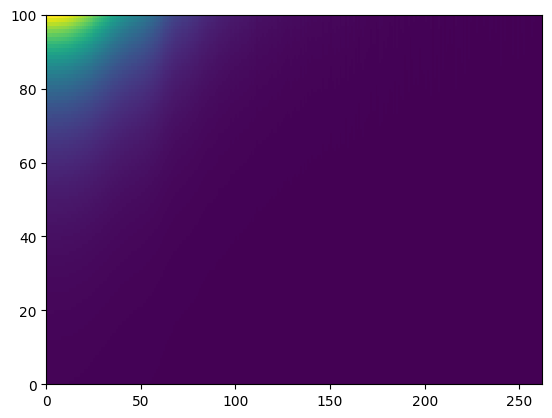

In [ ]:
from matplotlib import pyplot as plt
plt.pcolormesh(sol.ys)

In [ ]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/batched"
k = np.load(parent_dir + "/k.npy")  # (262,)'')

Text(0.5, 1.0, 'z=5')

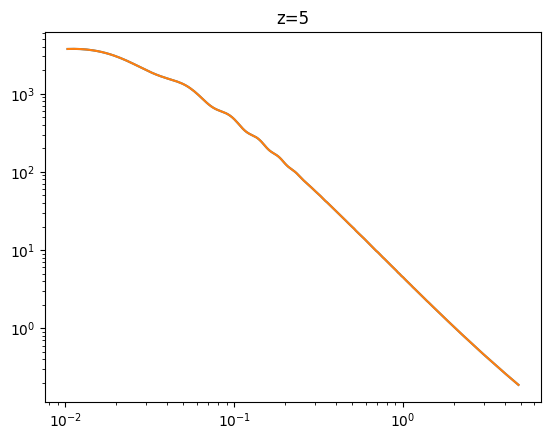

In [ ]:
plt.plot(k, sol.ys[0])
plt.plot(k, pk_all[:,::-1][0, 0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=5')

Text(0.5, 1.0, '10 time stpes later')

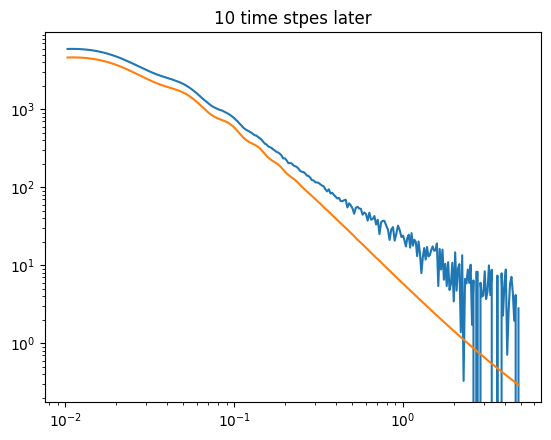

: 

In [ ]:
plt.plot(k, sol.ys[12])
plt.plot(k, pk_all[:,::-1][0, 12])
plt.xscale('log')
plt.yscale('log')
plt.title('10 time stpes later')

In [ ]:
np.shape(sol.ys)

(100, 262)

In [72]:
np.shape(pk_all)

(30000, 50, 262)